### Single Task Learner

In [2]:
from builtins import print
import numpy as np
import pandas as pd
import matplotlib
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.generic_utils import CustomObjectScope
#from tensorflow.keras.utils import CustomObjectScope

import tensorflow_addons as tfa

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
import os
import operator

#import utils

from utils.constants import UNIVARIATE_DATASET_NAMES as DATASET_NAMES
from utils.constants import UNIVARIATE_DATASET_NAMES_2018 as DATASET_NAMES_2018
from utils.constants import ARCHIVE_NAMES  as ARCHIVE_NAMES
from utils.constants import CLASSIFIERS
from utils.constants import ITERATIONS
from utils.constants import MTS_DATASET_NAMES

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder

import tensorflow.keras as keras

from scipy.interpolate import interp1d
from scipy.io import loadmat

In [357]:
#root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl"

def readucr(filename):
    print(filename)
    data = np.loadtxt(filename, delimiter=',')
    Y = data[:, 0]
    X = data[:, 1:]
    return X, Y

def read_dataset(root_dir, archive_name, dataset_name, task1):
    
    prefix = '' if task1 else '_Exp' 
    datasets_dict = {}
    cur_root_dir = root_dir.replace('-temp', '')

    file_name = cur_root_dir + '/archives/' + archive_name + '/' + dataset_name + prefix + '/' + dataset_name 
    x_train, y_train = readucr(file_name + prefix + '_TRAIN')
    x_test, y_test = readucr(file_name + prefix + '_TEST')
    datasets_dict[dataset_name] = (x_train.copy(), y_train.copy(), x_test.copy(),
                                   y_test.copy())
    
    return datasets_dict


def calculate_attributions(root_dir, prefix, train_data=True, task1= True):
    import tensorflow.keras as keras
    import sklearn
    
    classifier = 'fcn_mt'
    archive_name = 'ucr'
    dataset_name = 'GunPoint'

    max_length = 2000
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, task1)
    
    if train_data == True:
        x_train = datasets_dict[dataset_name][0]
        y_train = datasets_dict[dataset_name][1]
    else: 
        x_train = datasets_dict[dataset_name][2]
        y_train = datasets_dict[dataset_name][3]
    
    print(len(x_train))
    y_test = datasets_dict[dataset_name][3]
    
    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)


    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model = keras.models.load_model(
        root_dir + '/results/' + classifier + '/'  + prefix + '/'\
            + dataset_name + '/best_model.hdf5',compile=False)

    # filters
    relu, softm = (-4,-2) if task1 else (-4,-1)
    
    w_k_c = model.layers[softm].get_weights()[0]  # weights for each filter k for each class c

    # the same input
    new_input_layer = model.inputs

    # Output is both the original as well as the before last layer
    # layers[-3] : KerasTensor(type_spec=TensorSpec(shape=(None, 150, 128), dtype=tf.float32, name=None), name='activation_8/Relu:0', description="created by layer 'activation_8'") 
    # layers[-1] : KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")

    new_output_layer = [model.layers[relu].output, model.layers[softm].output]

    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    classes = np.unique(y_train)
    
    attr = []
    #print(classes)

    for c in classes:
        #plt.figure()
        #print(c)
        count = 0
        #find all time series for a class
        ts_class = np.where(y_train == c)
        #get time series data 
        c_x_train = x_train[ts_class]
        for idx,ts in enumerate(c_x_train):
            ts_nr=ts_class[0][idx]
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            pred_label = np.argmax(predicted)
            orig_label = np.argmax(enc.transform([[c]]))
            if True: 
                cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))
                for k, w in enumerate(w_k_c[:, orig_label]):
                    cas += w * conv_out[0, :, k] 
                minimum = np.min(cas)
                cas = cas - minimum
                cas = cas / max(cas)
                cas = cas * 100
                x = np.linspace(0, ts.shape[1] - 1, max_length, endpoint=True)
                # linear interpolation to smooth
                f = interp1d(range(ts.shape[1]), ts[0, :, 0])
                y = f(x)
                f = interp1d(range(ts.shape[1]), cas)
                cas = f(x).astype(int)
                
                if task1 == False:
                    pred_label = pred_label if pred_label <2 else pred_label + 1
                    orig_label = orig_label if orig_label <2 else orig_label + 1
                
                attr.append([ts_nr,x,y,cas,pred_label,orig_label])
    return sorted(attr, key=lambda x: x[0])

#attr = calculate_attributions(root_dir, "Unbalanced",True, task1=True)


In [288]:
def get_len_and_step_size(attributions, slices=5):
    attr_len  = len(attributions)
    step_size = int(attr_len / slices)
    return attr_len,step_size

def highest_mean_attribution(att,slices): 
    attr_len, step_size = get_len_and_step_size(att,slices)
    candidates = []
    for x in range(0,attr_len,step_size):
        candidates.append(att[x:x+step_size-1].mean())
    return np.argmax(candidates), candidates

def find_lower_upper_bound(att,slices): 
    attr_len, step_size = get_len_and_step_size(att,slices)
    l1,l2,sl = (0,0,0)
    highest_mean, curr_mean = (0,0)
    boundaries = []
    for i,x in enumerate(range(0,attr_len,step_size)):
        lower_bound = attr[ts][1][x]
        upper_bound = attr[ts][1][x+step_size-1]
        boundaries.append((lower_bound,upper_bound))
        cur_mean = att[x:x+step_size-1].mean()
        #print(cur_mean)
        if cur_mean > highest_mean: 
            sl = i
            highest_mean = cur_mean 
            l1,l2 = (lower_bound, upper_bound)
    return l1,l2,sl,boundaries



In [336]:
%matplotlib inline



def plot_attributions(ts,slices,attr_STL, attr_Unba_task_1,attr_Unba_task_2): 
    
    def plot_axv_lines(ax): 
        axes[ax].axvline(boundaries[0][0],color="black",alpha=0.3)
        for i in range(slices):
            #print(boundaries)
            axes[ax].axvline(boundaries[i][1],color="black",alpha=0.3)
    #ts = 30
    #slices = 5
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    #sp = plt.scatter(x=attr[ts][1], y=attr[ts][2], c=attr[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)
    # STL
    axes[0].scatter(x=attr_STL[ts][1], y=attr_STL[ts][2], c=attr_STL[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
    l1,l2,sl,boundaries = find_lower_upper_bound(attr_STL[ts][3],5)
    axes[0].axvspan(l1,l2,color="red",alpha=0.3)
    axes[0].set_title(f"STL: {sl}, pred: {attr_STL[ts][4]}, true: {attr_STL[ts][5]}")
    plot_axv_lines(0)
    # Unbalanced MTL 
    # Task 1
    axes[1].scatter(x=attr_Unba_task_1[ts][1], y=attr_Unba_task_1[ts][2], c=attr_Unba_task_1[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
    l1,l2,sl,boundaries = find_lower_upper_bound(attr_Unba_task_1[ts][3],5)
    axes[1].axvspan(l1,l2,color="red",alpha=0.3)
    axes[1].set_title(f"MTL task1: {sl}, pred: {attr_Unba_task_1[ts][4]}, true: {attr_Unba_task_1[ts][5]}")
    plot_axv_lines(1)
    # Task 2
    axes[2].scatter(x=attr_Unba_task_2[ts][1], y=attr_Unba_task_2[ts][2], c=attr_Unba_task_2[ts][3], cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)
    l1,l2,sl,boundaries = find_lower_upper_bound(attr_Unba_task_2[ts][3],5)
    axes[2].axvspan(l1,l2,color="red",alpha=0.3)
    axes[2].axvspan(boundaries[attr_Unba_task_2[ts][4]][0],boundaries[attr_Unba_task_2[ts][4]][1],color="blue",alpha=0.3,label="ss")
    axes[2].set_title(f"MTL task2: {sl}, pred: {attr_Unba_task_2[ts][4]}, true: {attr_Unba_task_2[ts][5]}")
    plot_axv_lines(2)
    _, candidates = highest_mean_attribution(attr_Unba_task_2[ts][3],5)
    #print(candidates)
    #print(attr_Unba_task_2[ts][3][399:799])#/400)
    #print(attr_Unba_task_2[ts][3][799:1199])#/400)

    #fig.colorbar(sp)
    #fig.tight_layout()
    plt.show

In [362]:
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
attr_STL = calculate_attributions(root_dir, "STL", True)
attr_Unba_task_1 = calculate_attributions(root_dir, "Unbalanced", train_data=True, task1=True)
attr_Unba_task_2 = calculate_attributions(root_dir, "Unbalanced", train_data=True, task1=False)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
50
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
50
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint_Exp/GunPoint_Exp_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint_Exp/GunPoint_Exp_TEST
56


50


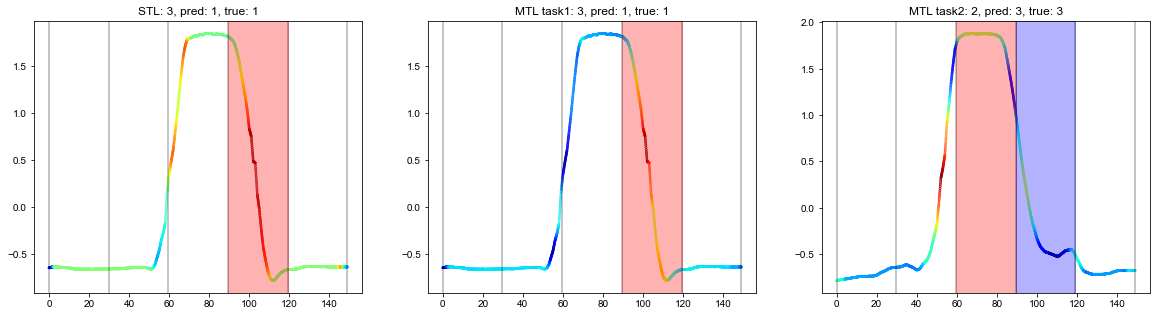

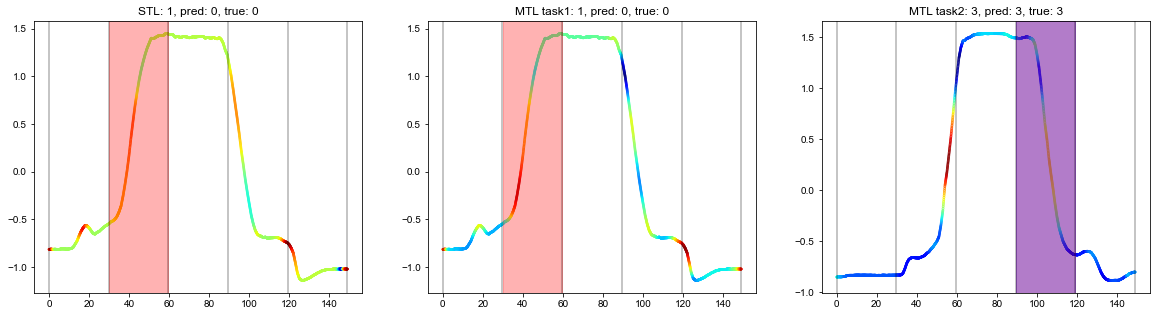

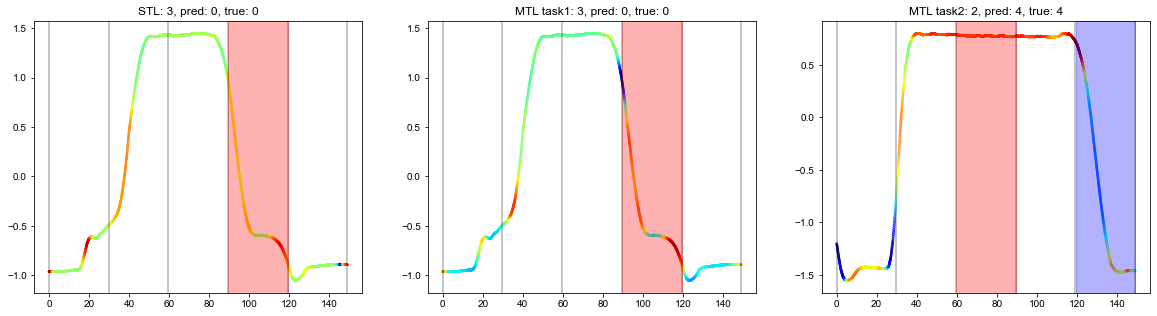

In [363]:
#Examples 
examples = [0,10,30]
print(len(attr_STL))
slices = 5
for ts in examples:
    plot_attributions(ts,slices,attr_STL, attr_Unba_task_1,attr_Unba_task_2)

In [365]:
root_dir = "G:/My Drive/master thesis/code/dl-4-tsc-mtl" 
attr_STL_test = calculate_attributions(root_dir, "STL", train_data=False)
attr_Unba_task_1_test = calculate_attributions(root_dir, "Unbalanced", train_data=False, task1=True)
attr_Unba_task_2_test = calculate_attributions(root_dir, "Unbalanced", train_data=False, task1=False)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
150
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint/GunPoint_TEST
150
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint_Exp/GunPoint_Exp_TRAIN
G:/My Drive/master thesis/code/dl-4-tsc-mtl/archives/ucr/GunPoint_Exp/GunPoint_Exp_TEST
56


56


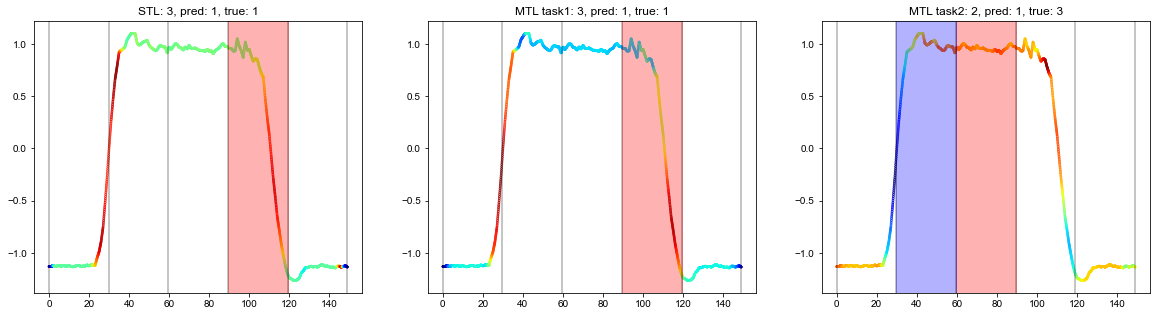

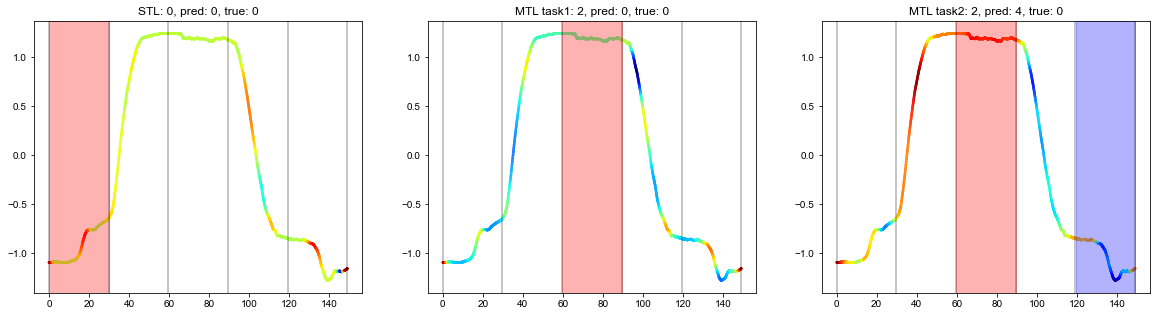

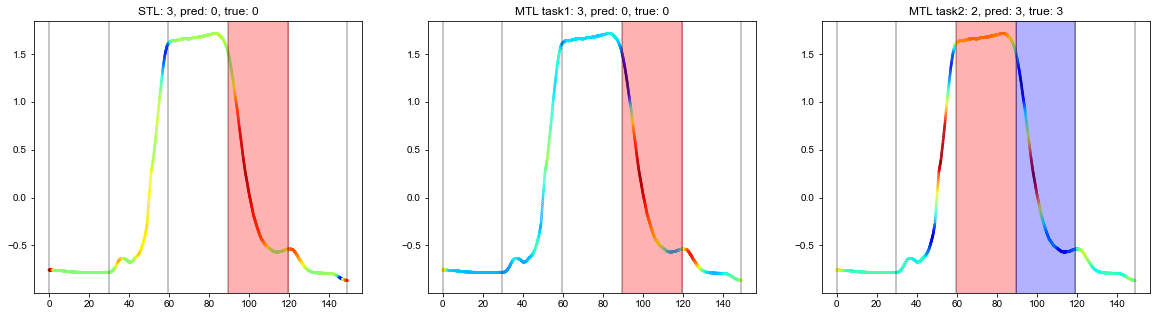

In [356]:
#Examples 
examples = [0,50,55]
print(len(attr_STL))
#ts = 30
slices = 5
for ts in examples:
    plot_attributions(ts,slices,attr_STL_test, attr_Unba_task_1_test,attr_Unba_task_2_test)